<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/08_custom_dataset_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация типов кораблей

Датасет состоит из изображений 400х400 со следующими типами кораблей:
* Контейнеровоз (Cargo)
* Судно береговой охраны (Coast Guard)
* Паром (Ferry)
* Рыболовецкое судно (Fishing)
* Буксир (Tug)

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import numpy as np
import glob
import imageio

import matplotlib.pyplot as plt
from scipy.misc import toimage
from IPython.display import Image
%matplotlib inline 

from keras import backend as K

Using TensorFlow backend.


# Подготовка данных

## Загрузка данных с Google Drive

In [69]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# !cp /content/gdrive/'My Drive'/neural/boatset.zip boatset.zip
# !unzip boatset.zip
!rm -rf __MACOSX
!rm -rf .DS_Store

## Входные параметры

In [0]:
# K.clear_session()

# Пути к изображениям
root_folder = "boatset"
train_folder = root_folder + '/train'
val_folder = root_folder + '/val'
test_folder = root_folder + "/test"


# Размеры изображений
image_height, image_width = 400, 400
target_size = (image_height, image_width)
target_shape = (image_height, image_width, 3)

# Классы изображений
num_classes = 5
classes = {0: "Контейнеровоз", 1: "Береговая охрана", 2: "Паром", 3: "Рыболовецкое судно", 4: "Буксир"}

# Другое
batch_size = 4

## Генератор изображений

In [3]:
# Train generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

print("Train classes", train_generator.class_indices)

# Validation generator
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)
print("Val classes", train_generator.class_indices)

Found 995 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
Found 160 images belonging to 5 classes.
Val classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}


# Подготовка нейросети

## Создание нейросети

### Нейросеть на основе Inception

In [0]:
def inception():
  print("Loading Inception")

  base_model = InceptionV3(
      weights='imagenet', 
      include_top=False, 
      input_shape=input_shape)

  for layer in base_model.layers:
      layer.trainable = False

  print("Inception loaded")
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(input=base_model.input, output=predictions)

  opt = Adam(lr=1e-4)
#   opt = RMSprop(lr=0.0005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='binary_crossentropy',
                optimizer=opt, 
                metrics=['accuracy'])
  return model


## Обучение нейросети

(400, 400, 3)
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
249/249 [==============================] - 38s 153ms/step - loss: 0.4306 - acc: 0.8201 - val_loss: 0.3324 - val_acc: 0.8650
Epoch 2/20
249/249 [==============================] - 33s 132ms/step - loss: 0.3603 - acc: 0.8527 - val_loss: 0.3102 - val_acc: 0.8675
Epoch 3/20
249/249 [==============================] - 33s 132ms/step - loss: 0.3018 - acc: 0.8772 - val_loss: 0.2973 - val_acc: 0.8738
Epoch 4/20
249/249 [==============================] - 33s 131ms/step - loss: 0.3026 - acc: 0.8748 - val_loss: 0.2657 - val_acc: 0.8788
Epoch 5/20
249/249 [==============================] - 33s 132ms/step - loss: 0.2665 - acc: 0.8941 - val_loss: 0.2612 - val_acc: 0.8838
Epoch 6/20
249/249 [==============================] - 33s 132ms/step - loss: 0.2637 - acc: 0.8955 - val_loss: 0.2499 - val_acc: 0.8925
Epoch 7/20
249/249 [==============================] - 33s 131ms/step - loss: 0.2513 - acc: 0.8987 - val_loss: 0.2487 - val_acc: 

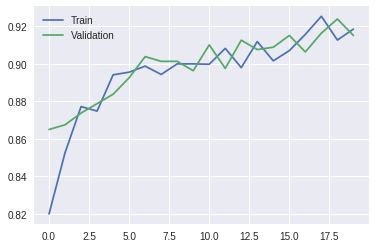

In [6]:
train_generator.reset()
val_generator.reset()

print(target_shape)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=20,
    verbose=1)

plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

### Дообучение

Epoch 1/5
249/249 [==============================] - 35s 142ms/step - loss: 0.2323 - acc: 0.9085 - val_loss: 0.1995 - val_acc: 0.9150
Epoch 2/5
249/249 [==============================] - 33s 131ms/step - loss: 0.2166 - acc: 0.9114 - val_loss: 0.1987 - val_acc: 0.9175
Epoch 3/5
249/249 [==============================] - 33s 131ms/step - loss: 0.2260 - acc: 0.9037 - val_loss: 0.1982 - val_acc: 0.9163
Epoch 4/5
249/249 [==============================] - 33s 131ms/step - loss: 0.2081 - acc: 0.9156 - val_loss: 0.1978 - val_acc: 0.9163
Epoch 5/5
249/249 [==============================] - 32s 130ms/step - loss: 0.1955 - acc: 0.9218 - val_loss: 0.1975 - val_acc: 0.9162


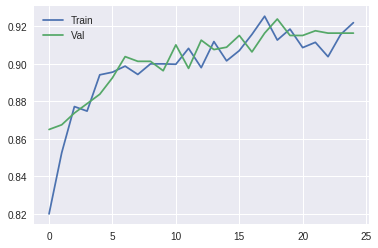

In [7]:
opt = SGD(lr=3e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs=5,
    verbose=1)

acc = []
acc.extend(history.history['acc'])
acc.extend(history1.history['acc'])

val_acc = []
val_acc.extend(history.history['val_acc'])
val_acc.extend(history1.history['val_acc'])

plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.show()

# Демонстрация распознавания

## Утилиты

In [0]:
def evaluate_folder(folder):
  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_directory(
    folder,
    target_size = target_size,
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'categorical')
  generator.reset()
  print("Train classes", generator.class_indices)
  return model.evaluate_generator(
      generator, 
      steps = generator.samples // batch_size,
      verbose = 1)

def read_image(filename):
    return imageio.imread(filename)

def predict_single_image(content):
    x = content
    x = x / 255
    x = np.expand_dims(x, axis=0)
    
    prediction = model.predict(x)
    predicted = np.argmax(prediction, axis=-1)
    return predicted

## Распознавание размеченной выборки

In [9]:
print("---- Test ----\n")
train_eval = evaluate_folder(train_folder)
print(train_eval)

print("\n---- Validation ----\n")
val_eval = evaluate_folder(val_folder)
print(val_eval)


---- Test ----

Found 995 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
249/249 [==============================] - 28s 112ms/step - loss: 0.1841 - acc: 0.9329
[0.1840529704369917, 0.93286353]

---- Validation ----

Found 160 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast_guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
40/40 [==============================] - 4s 111ms/step - loss: 0.1975 - acc: 0.9163
[0.1975430894512101, 0.91625005]


## Демонстрация

In [19]:
test_files = glob.glob(test_folder + "/*.jpg")
test_files.sort()

for filename in test_files:
    content = read_image(filename)
    cl = predict_single_image(content)[0]
    print("%s -> %s" % (filename, classes[cl]))


['boatset/test/cargo_test_1.jpg', 'boatset/test/cargo_test_2.jpg', 'boatset/test/cargo_test_3.jpg', 'boatset/test/cargo_test_4.jpg', 'boatset/test/cargo_test_5.jpg', 'boatset/test/coast_guard_test_1.jpg', 'boatset/test/coast_guard_test_2.jpg', 'boatset/test/coast_guard_test_3.jpg', 'boatset/test/coast_guard_test_4.jpg', 'boatset/test/coast_guard_test_5.jpg', 'boatset/test/ferry_test_1.jpg', 'boatset/test/ferry_test_2.jpg', 'boatset/test/ferry_test_3.jpg', 'boatset/test/ferry_test_4.jpg', 'boatset/test/ferry_test_5.jpg', 'boatset/test/fishing_test_1.jpg', 'boatset/test/fishing_test_2.jpg', 'boatset/test/fishing_test_3.jpg', 'boatset/test/fishing_test_4.jpg', 'boatset/test/fishing_test_5.jpg', 'boatset/test/tug_test_1.jpg', 'boatset/test/tug_test_2.jpg', 'boatset/test/tug_test_3.jpg', 'boatset/test/tug_test_4.jpg', 'boatset/test/tug_test_5.jpg']
boatset/test/cargo_test_1.jpg -> Контейнеровоз
boatset/test/cargo_test_2.jpg -> Контейнеровоз
boatset/test/cargo_test_3.jpg -> Контейнеровоз
boa